In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.interpolate import interp1d

不使用滤波器生成目标功率谱密度噪声测试

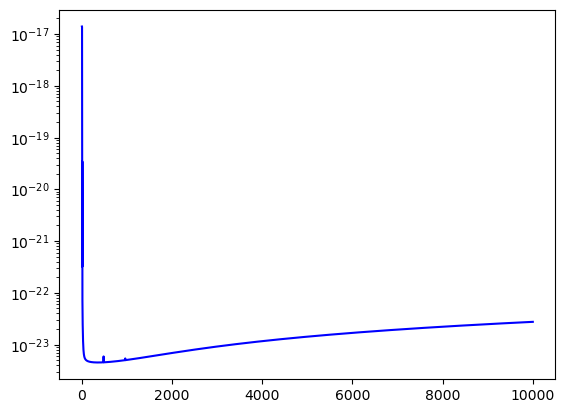

In [5]:

# 获取频率和噪声功率谱密度
freq_psd = np.loadtxt('aligo_design.txt')

freqs_ligo = freq_psd[:,0]
psd_ligo = freq_psd[:,1]
freqs_ligo[0] = 0

PSD_ligo_map =interp1d(freqs_ligo,psd_ligo)

fig = plt.figure()
plt.plot(freqs_ligo, psd_ligo, 'b')
plt.yscale('log')
plt.show()

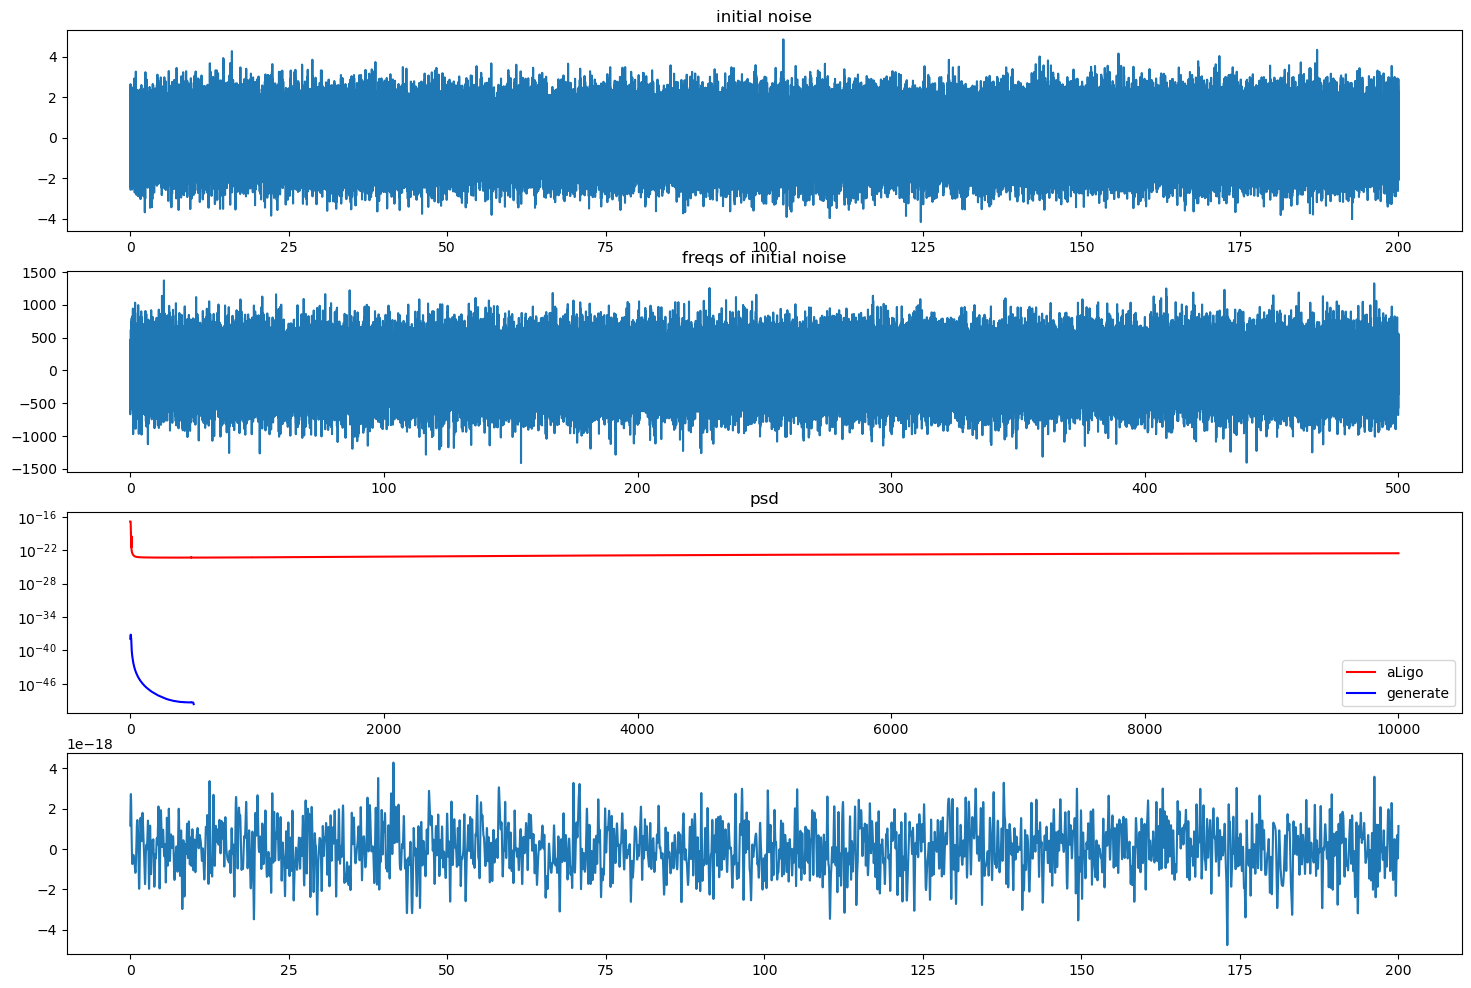

In [ ]:

nsamples = 200000
# nsamples = t * samples
timeVec =np.linspace(0,200,nsamples)
tlen = timeVec[-1] - timeVec[0]
samples = nsamples / tlen
# 生成初始噪声
initial_noise = np.random.normal(0,1,nsamples)
# 进行傅里叶变换
initial_noise_fft = np.fft.rfft(initial_noise)
# 获取噪声频率
initial_noise_freq = np.fft.rfftfreq(len(initial_noise),timeVec[1] - timeVec[0])


# 改变PSD
output_noise_fft = initial_noise_fft * PSD_ligo_map(initial_noise_freq)
# 逆傅里叶变换为时域
output_noise = np.fft.irfft(output_noise_fft)

f,pxx = welch(output_noise,fs=samples)

fig = plt.figure(figsize=(18,12))
plt.subplot(4,1,1)
plt.plot(timeVec,initial_noise)
plt.title("initial noise")

plt.subplot(4,1,2)
plt.plot(initial_noise_freq,initial_noise_fft)
plt.title("freqs of initial noise")


plt.subplot(4,1,3)
plt.plot(freqs_ligo,psd_ligo,'r',label = 'aLigo')
plt.plot(f,pxx,'b',label = 'generate')
plt.legend()
plt.yscale('log')
plt.title('psd')

plt.subplot(4,1,4)
plt.plot(timeVec,output_noise)
plt.show()



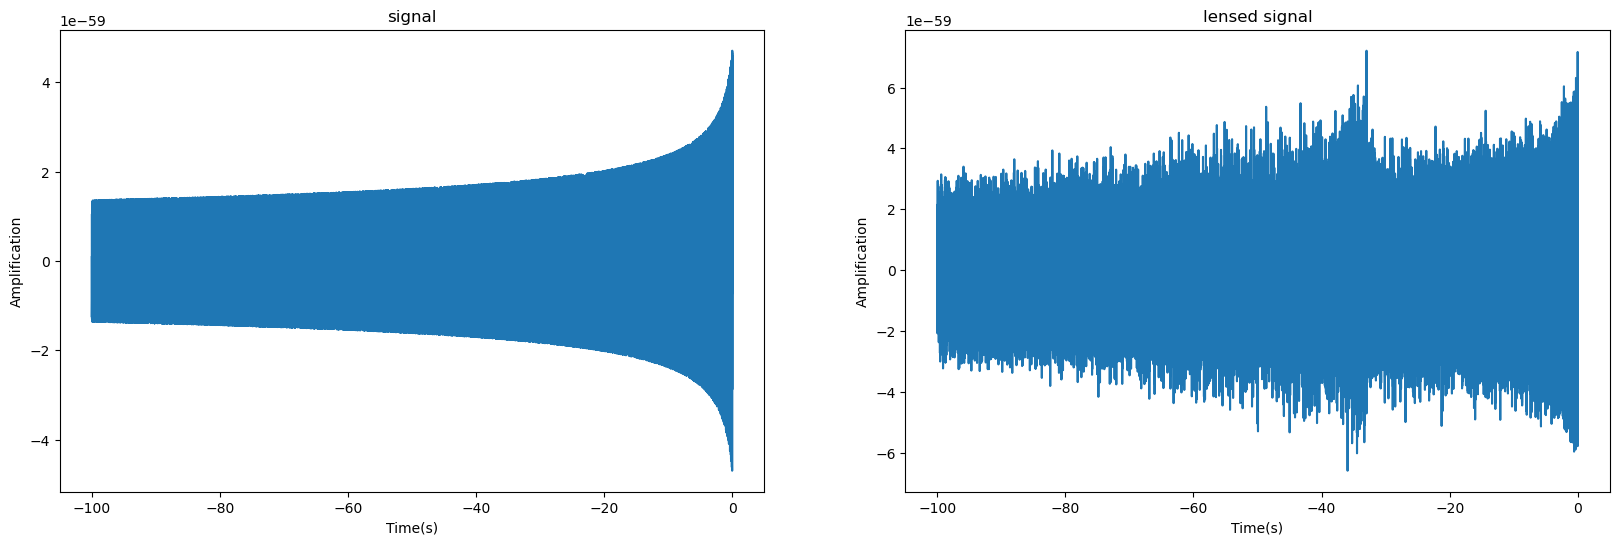

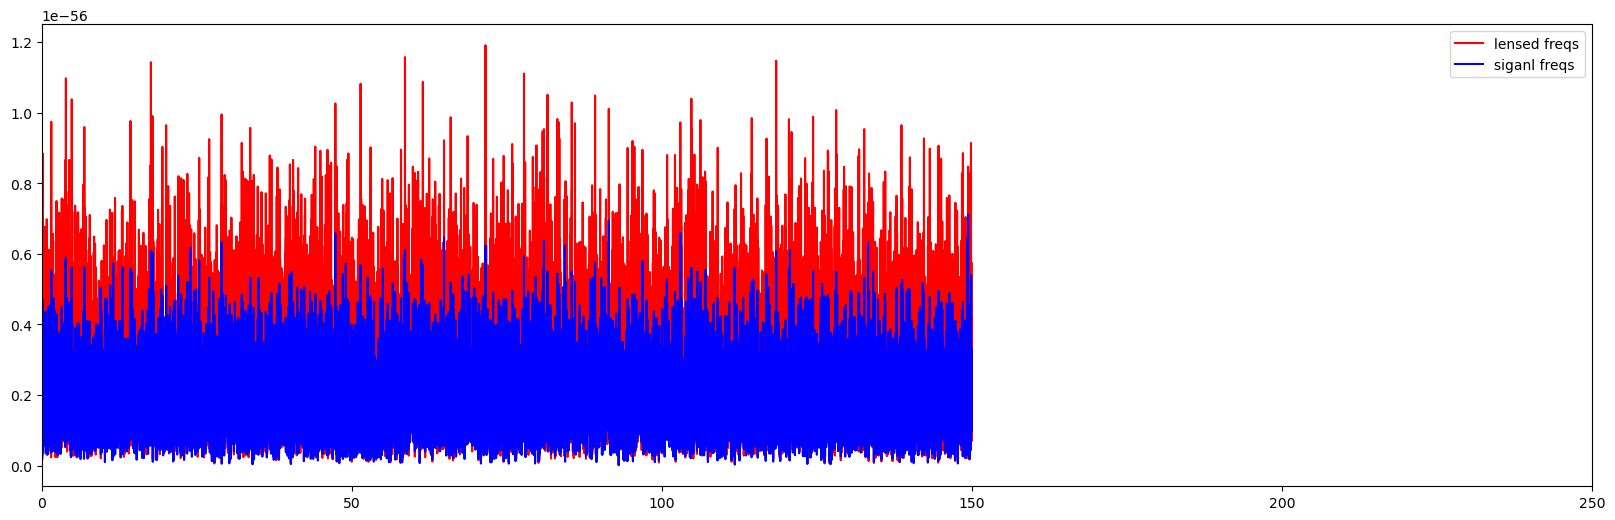

In [ ]:
# 常规导包
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, firwin2, fftconvolve,stft,filtfilt
from scipy.io import savemat,loadmat
from scipy.interpolate import interp1d


# 生成SIS模型波形

# 常量定义
# nsamples = 200000
# samples = 20000
G = 6.67430e-11  # 万有引力常数, m^3 kg^-1 s^-2
c = 2.998e8  # 光速, m/s
M_sun = 1.989e30  # 太阳质量, kg
pc = 3.086e16  # pc到m的转换

# 变量定义
# 定义质量变量
M1 = 10 * M_sun
M2 = 12 * M_sun
M = (M1 + M2)
v = M1 * M2 / M ** 2 # 质量比
M_c = v ** (3 / 5) * M  # 啁啾质量
M_c = 311
r = 1370.2970 * 1e6 * pc # 引力波源到观测者的距离  单位Mpc
t_c = 0.6831 # 合并时间
phi_c = 1.4867 * np.pi # 合并时刻的相位

# t = np.linspace(-100,0,30000)
t = np.arange(0,100,2000000)

# 定义引力波信号函数
def generate_h_t(t,M_c,r,phi_c):
    theta_t= c**3 *(t_c - t) / (5 * G * M_c)
    h = G * M_c /(c ** 2 * r) * theta_t**(-1/4)*np.cos(2*phi_c - 2*theta_t**(5/8))
    return h
# 生成信号
h = generate_h_t(t,M_c,r,phi_c)
h = h[:-1]
t = t[:-1]
# 去掉信号inf的情况
# 将信号转换到频域
h_f = np.fft.rfft(h)

# 生成频率
freqs = np.fft.rfftfreq(len(h),t[1] - t[0])

# 透镜参数定义
# Dl = 1e8 * pc  # 透镜到观测者的距离
# Ds = 1.5e8 * pc # 波源到透镜的距离
# Dls = Ds - Dl # 波源都观测者的距离
# v = 1e6 # 透镜系统的速度弥散
# zl = 0.5 # 红移
# Mlz = 4*np.pi**2 * v **4 *(1 + zl) * Dl * Dls / Ds
# print(Mlz / M_sun)
Mlz = 4.7315e5 * M_sun

omega = 2 * np.pi * freqs
w = G * 4 *Mlz * omega / c**3
y = 1.7680

# 定义光学极限的透镜化
def generate_f_geo(w,y):
    F_geo = np.sqrt(1 + 1/y) - 1j * np.lib.scimath.sqrt(-1 + 1 / y) * np.exp(1j * w * 2 * y)
    return F_geo
# 生成透镜化，频域
F_geo = generate_f_geo(w,y)

# h_lens = h * F_geo
# 将信号透镜化 （频域）
lens_f = h_f * F_geo
# 逆傅里叶变换将频域信号转换为时域信号
h_lens = np.fft.irfft(lens_f)

# 画图
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(t,h.real,label = 'signal')
plt.xlabel('Time(s)')
plt.ylabel('Amplification')
plt.title('signal')
t = t[:-1]
plt.subplot(1,2,2)
plt.plot(t,h_lens.real,label = 'lensed signal')
plt.xlabel('Time(s)')
plt.ylabel('Amplification')
plt.title('lensed signal')


plt.show()


plt.figure(figsize=(20,6))
plt.plot(freqs,np.abs(lens_f),'red',label = 'lensed freqs')
plt.plot(freqs,np.abs(h_f),'blue',label = 'siganl freqs')
plt.legend()
# plt.xlim(0,250)
plt.show()

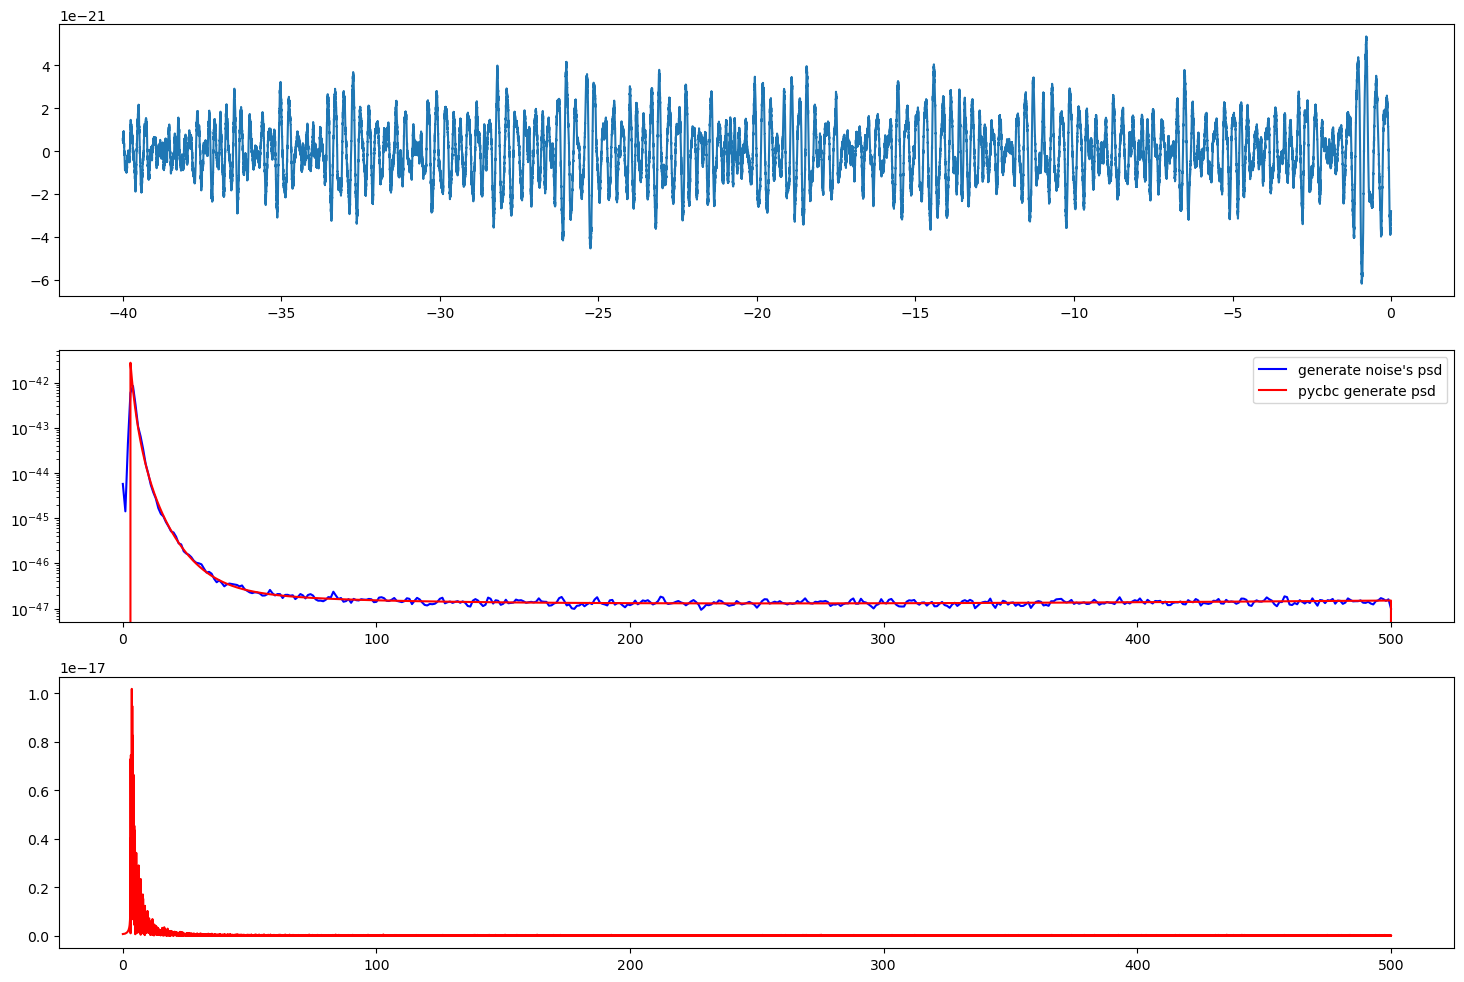

In [ ]:
import matplotlib.pyplot as plt
import pycbc.noise
import pycbc.psd
import numpy as np
from scipy.signal import welch

# psd 参数
flow = 3 # 最低频率为3Hz
delta_f = 1.0 / 40 # 频率分辨率
nyq_freq = 500
flen = int(nyq_freq / delta_f) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen,delta_f,flow)
# 噪声参数
delta_t = 1.0 / 1000  
tsamples = 40000
t = np.arange(-40,0,0.001)
duration = tsamples * delta_t
samples = tsamples / duration

outNoise = pycbc.noise.noise_from_psd(tsamples,delta_t,psd,seed= 123)
freqs = np.fft.rfftfreq(len(outNoise),t[1]-t[0])

f,pxx = welch(outNoise,fs = samples,nperseg=samples)
f_noise = np.fft.rfft(outNoise)
plt.figure(figsize=(18,12))
plt.subplot(311)
plt.plot(t,outNoise)

plt.subplot(312)
plt.plot(f,pxx,'b',label = "generate noise's psd")
plt.plot(freqs,psd,'r',label = "pycbc generate psd")
plt.yscale('log')
plt.legend()
# plt.xscale('log')
plt.subplot(313)
plt.plot(freqs,np.abs(f_noise),'r')
plt.show()

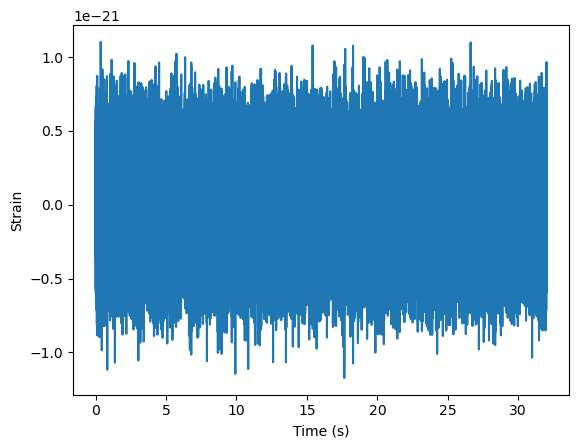

In [2]:
import matplotlib.pyplot as pp
import pycbc.noise
import pycbc.psd

# The color of the noise matches a PSD which you provide
flow = 30.0
delta_f = 1.0 / 16
flen = int(2048 / delta_f) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
# Generate 32 seconds of noise at 4096 Hz
delta_t = 1.0 / 4096
tsamples = int(32 / delta_t)
ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127) 

pp.plot(ts.sample_times, ts)
pp.ylabel('Strain')
pp.xlabel('Time (s)')
pp.show()

In [5]:
import lal
import numpy
seed = numpy.random.randint(2**32)

randomness = lal.gsl_rng("ranlux", seed)
random_number = randomness.uniform()  # 生成一个 [0, 1) 范围内的均匀分布随机数
print("生成的随机数:", random_number)

生成的随机数: 0.3742852807044983
